<a href="https://it-omscholing.nl/locaties/hogeschool-rotterdam/">
<div>
<a><img src='pics/banner.PNG'/></a>
</div>
<div>
<a href=''><img src='pics/miw.PNG'/></a>
<em>Author: Jeroen Boogaard</em>
</div>
</a>

<h1>Practicum SQL met <a href="https://geopandas.org/en/stable/index.html">GeoPandas</a></h1>
<img src="pics/geopandas_icon.png" width="25%" height="25%"/>

<h2>Environment Variables</h2>

<h2>Environment Variables</h2>

In [171]:
import os
os.environ['export PYSPARK_DRIVER_PYTHON'] = 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] ='notebook'
os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'

In [172]:
# pip install geoplot

In [173]:
# !pip install pyarrow

<h2>Imports<h2>

In [174]:
from pyspark import SparkContext as sc
from pyspark.sql import SparkSession

import pyspark.sql
import pandas as pd
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import geopandas as gpd
# import geoplot
import numpy as np
import contextily as ctx

from pyspark.sql import functions as F

<h2>Data Visualization</h2>

<h3>Extract</h3>

In [175]:
data_dir = "geo/ref-nuts-2021-01m/"
euPath = data_dir + "NUTS_RG_01M_2021_3035_LEVL_1.json"
gdf = gpd.read_file(euPath)

<h3>Transform</h3>

In [176]:
gdf.crs = "EPSG:3035"
gdfBen = gdf[(gdf.CNTR_CODE == "BE") | (gdf.CNTR_CODE == "NL") | (gdf.CNTR_CODE == "LU")]
gdfCrsBen = gdfBen.to_crs("EPSG:3857")
gdfNl = gdf[gdf.CNTR_CODE == "NL"]
gdfCrsNl = gdfNl.to_crs("EPSG:3857")

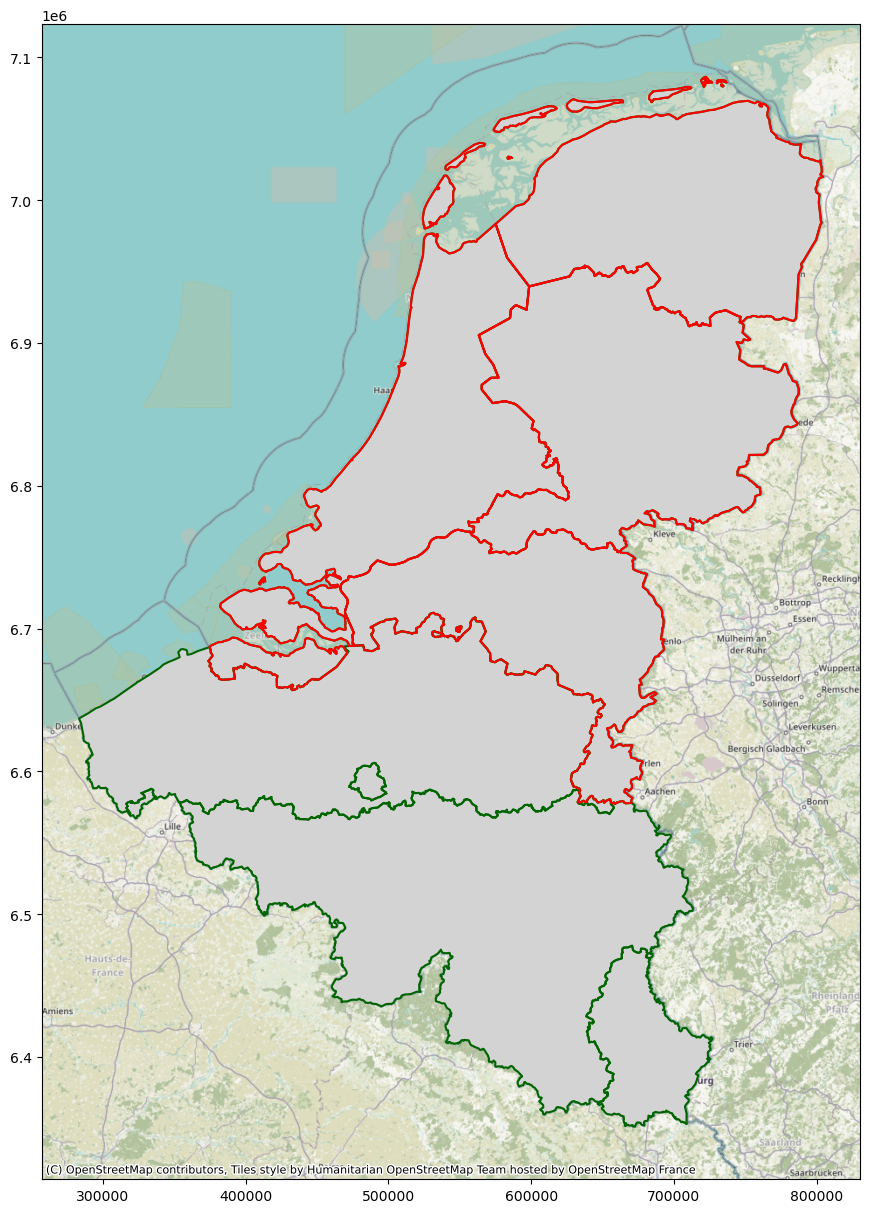

In [177]:
ax = gdfCrsBen.plot(figsize=(20,15), color="lightgray")

# Grenzen Benelux landen
gdfCrsBen.boundary.plot(color="darkgreen", ax=ax)

# Provincies Nederland
gdfCrsNl.boundary.plot(color="red", ax=ax)

# add background map by OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.HOT)

**Ingezoomed op de Benelux en Nederland gemarkeerd**

<h3>Transform</h3>

<h2>PySpark</h2>

Load

In [178]:
eurCsvFile = "csv/countries_europe.csv"
euCsvFile = "csv/european_union.csv"
eurCodesCsvFile = "csv/country-codes.csv"
gdfCSVFile= "csv/gdf.csv"
gdfEuCSVFile= "csv/gdfEu.csv"
gdfEu2CSVFile= "csv/gdfEu2.csv"

gdfRedCSVFile = "csv/gdfRed.csv"

In [179]:
# Create a Spark Session
spark = SparkSession.builder.appName('SQL').getOrCreate()

In [180]:
# Create Spark dataframe from csvfile : marked as sp for clarity of Spark dataframe
spEurDf = spark.read.csv(eurCsvFile, inferSchema=True, header=True)
spEurDf.printSchema()
spEuDf = spark.read.csv(euCsvFile, inferSchema=True, header=True)
# spEuDf.printSchema()
spEurCodesDf = spark.read.csv(eurCodesCsvFile, inferSchema=True, header=True)
# spEurCodesDf.printSchema()

root
 |-- zoom: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- abbreviation: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- ISO numeric: integer (nullable = true)
 |-- land area km: double (nullable = true)
 |-- population: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- continent: string (nullable = true)



In [181]:
# Create a view
spEurDf.createOrReplaceTempView('countries')

In [182]:
spEuDf.createOrReplaceTempView('eu')

In [183]:
spEurCodesDf.createOrReplaceTempView('codes')

**query op het dataframe via <i>methods</i>**

spEurDf.select("Code").show(10)

**<i>SQL</i> query op het dataframe**

countriesQuery = """
    SELECT Code
    FROM countries
"""

spEurCodes = spark.sql(countriesQuery)
spEurCodes.show(10)

spEurDf.select("Code").show(10)

<h3>Exercise 1</h3>
<p>
Maak op dezelfde manier dataframes euDf en eurCodesDf aan door het importeren vanuit de csv-files
</p>

# Zie uitwerkingen onder Pyspark - load sectie

In [184]:
spEurCodesDf.select("ISO3166-1-Alpha-2").toPandas()

,ISO3166-1-Alpha-2
0,TW
1,AF
2,AL
3,DZ
4,AS
...,...
245,EH
246,YE
247,ZM
248,ZW


<h3>Exercise 2a</h3>
<p>
    Maak een <u>koppeling</u> tussen <u>euDf</u> en <u>eurCodesDf</u> via kolom <u>Code</u> en <u>ISO3166-1-Alpha-3</u> 
</p>

In [185]:
# print (type(euDf)) # type weergeven
# print (type(eurCodesDf)) # type weergeven

pdEuDf = spEuDf.toPandas() #omzetten naar pandas: marked as pd for Pandas clarity
pdEurCodesDf = spEurCodesDf.toPandas() #omzetten naar pandas

/Users/JABoo/miniconda3/envs/miw3/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [186]:
# pdEurCodesDf.columns # weergeven kolommen eurCodesDf
# pdEuDf.columns # weergeven kolommen euDf

In [187]:
pd.DataFrame.head(pd.merge(pdEuDf, pdEurCodesDf, left_on=  ['Code'],
                   right_on= ['ISO3166-1-Alpha-3'], 
                   how = 'left'))

#koppeling gemaakt door alles in 1 tabel te zetten

,Code,Name,Member-Since,FIFA,Dial,ISO3166-1-Alpha-3,MARC,is_independent,ISO3166-1-numeric,GAUL,...,Sub-region Name,official_name_ru,Global Name,Capital,Continent,TLD,Languages,Geoname ID,CLDR display name,EDGAR
0,AUT,Austria,1995-01-01,AUT,43,AUT,au,Yes,40.0,18,...,Western Europe,Австрия,World,Vienna,EU,.at,"de-AT,hr,hu,sl",2782113.0,Austria,C4
1,BEL,Belgium,1958-01-01,BEL,32,BEL,be,Yes,56.0,27,...,Western Europe,Бельгия,World,Brussels,EU,.be,"nl-BE,fr-BE,de-BE",2802361.0,Belgium,C9
2,BGR,Bulgaria,2007-01-01,BUL,359,BGR,bu,Yes,100.0,41,...,Eastern Europe,Болгария,World,Sofia,EU,.bg,"bg,tr-BG,rom",732800.0,Bulgaria,E0
3,HRV,Croatia,2013-07-01,CRO,385,HRV,ci,Yes,191.0,62,...,Southern Europe,Хорватия,World,Zagreb,EU,.hr,"hr-HR,sr",3202326.0,Croatia,1M
4,CYP,Cyprus,2004-05-01,CYP,357,CYP,cy,Yes,196.0,64,...,Western Asia,Кипр,World,Nicosia,EU,.cy,"el-CY,tr-CY,en",146669.0,Cyprus,G4


<h3>Exercise 2b</h3>

<h4>Gegeven</h4>

<p>De dataset gdf bevat tweeletterige landcodes die je ook kunt terugvinden in de dataset <u>eurCodesDf</u></>

In [212]:
euCodes = gdf.CNTR_CODE.tolist()
euCodes = [euCode.replace(",", "") for euCode in euCodes]
print(euCodes)

In [213]:
gdf.crs = "EPSG:3035"
gdfEu = gdf[gdf.CNTR_CODE == euCodes]
gdfCrsEu = gdfEu.to_crs("EPSG:3005")

<AxesSubplot: >

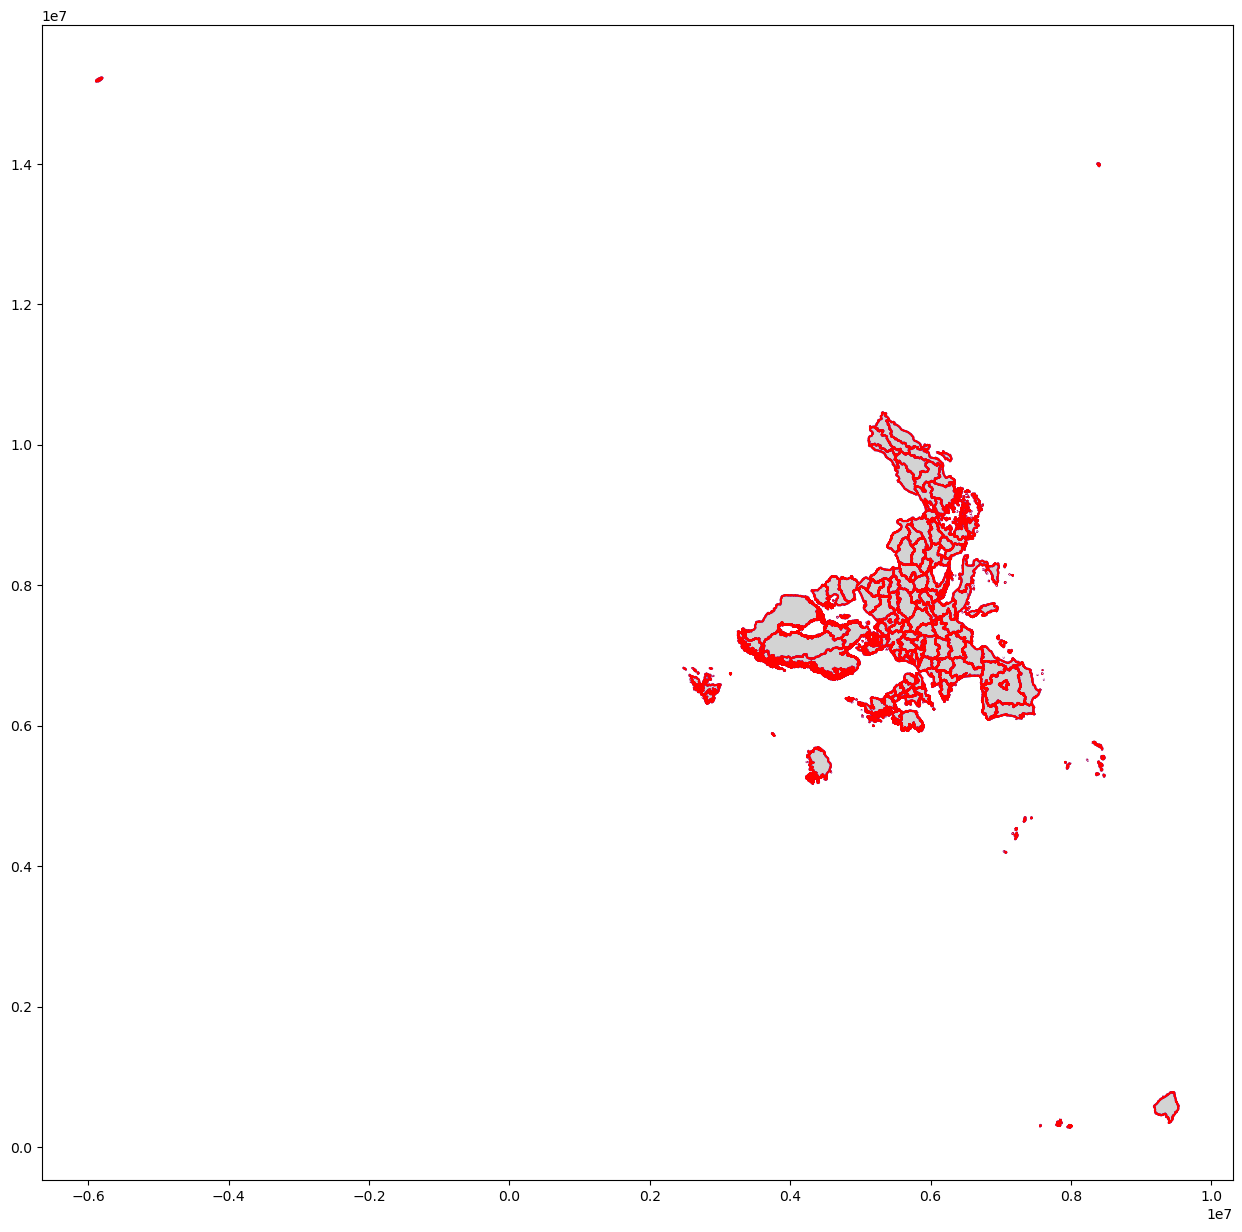

22/12/16 14:59:21 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 123115 ms exceeds timeout 120000 ms
22/12/16 14:59:21 WARN SparkContext: Killing executors is not supported by current scheduler.


In [214]:
ax = gdfCrsEu.plot(figsize=(20,15), color="lightgray")

# Grenzen Benelux landen
gdfCrsEu.boundary.plot(color="blue", ax=ax)

# Provincies Nederland
gdfCrsEu.boundary.plot(color="red", ax=ax)

<h4>Gevraagd</h4>
<p>
    Maak een geopandas dataframe <u>gdfEu</u> gebaseerd op <u>gdf</u> en markeer hierin de EU landen met <span style="color:red">rood</span>.
    <strong>Hint</strong>Gebruik de koppeling uit 2a voor het verkrijgen van de tweeletterige landcodes van EU landen en filter daarmee het geodataframe.
</p>

<h4>Oplossing</h4>

In [192]:
# print (gdf.columns) #kolomnamen weergeven
# print (pdEurCodesDf.columns) #kolomnamen weergeven

In [193]:
# merge gebruikt omdat beide nu pandas zijn

# gdfEu = pd.merge(gdf, pdEurCodesDf,  how='right', left_on=['CNTR_CODE'], right_on = ['ISO3166-1-Alpha-2']) # gebaseerd op eurCodesDf met 324 rijen
gdfEu = pd.merge(gdf, pdEurCodesDf,  how='left', left_on=['CNTR_CODE'], right_on = ['ISO3166-1-Alpha-2']) # gebaseerd op gdf met 125 rijen

# pdEurCodesDf.head
# gdfEu.to_csv(gdfEuCSVFile) # created csv for ease of use with spark

In [194]:
# pdEuDf.show(27) # showing table to find "member since"

gdfEu2 = pd.merge(gdfEu, pdEuDf,  how='left', left_on=['ISO3166-1-Alpha-3'], right_on = ['Code']) # gebaseerd op gdf met 125 rijen

# gdfEu2.iloc[:,[69]]
gdfEu2.rename(columns={'Member-Since': 'Member'}, inplace=True) # To use in pyspark

# gdfEu2.to_csv(gdfEu2CSVFile) # created csv for ease of use with spark

In [195]:
# Create Spark dataframe from csvfile : marked as sp for clarity of Spark dataframe
spGdfEu = spark.read.csv(gdfEuCSVFile, inferSchema=True, header=True) # voorbereiding 2b
# spGdfEu.printSchema()
spGdfEu2 = spark.read.csv(gdfEu2CSVFile, inferSchema=True, header=True) # voorbereiding 2b
# spGdfEu2.printSchema()

AnalysisException: Path does not exist: file:/Users/JABoo/workspace/hr/cursisten/pieter/Deliverables periode 3/csv/gdfEu.csv

In [ ]:
# Create Views
spGdfEu.createOrReplaceTempView('geodata') # includes columns from eurCodesCsvFile in cell

In [ ]:
spGdfEu2.createOrReplaceTempView('geodata2') # includes columns from euCsvFile and eurCodesCsvFile

In [ ]:
# uitwerking met alle data van EU territorium

euAllDataQuery = """
    SELECT *
    FROM geodata2
    WHERE geodata2.Member IS NOT NULL
"""

pdAllData = spark.sql(euAllDataQuery).toPandas()

# df.style.highlight_null(null_color='red')

# pd.set_option('display.max_rows', pdAllData.shape[0]+1) # to disable displaying only 20 rows
pdAllData

# print (type(euAllDataQuery))

In [ ]:
# uitwerking met alleen Namen van EU teritorium , geometry

euQuery = """
    SELECT NAME_LATN, Member, 
    FROM geodata2
    WHERE geodata2.Member IS NOT NULL
"""

pdGdfEuRed = spark.sql(euQuery).toPandas()

# function for set text color of positive
# values in Dataframes
def color_eu_red(val):
	"""
	Takes a scalar and returns a string with
	the css property `'color: green'` for positive
	strings, black otherwise.
	"""
	if val:
		color = 'red'
	else:
		color = 'black'
	return 'color: %s' % color

# pd.set_option('display.max_rows', pdGdfEuRed.shape[0]+1) # to disable displaying only 20 rows
pdGdfEuRed.head(1).style.applymap(color_eu_red)

In [ ]:
pdGdfEuRed.tolist()

In [ ]:
pdGdfEuRed.to_csv(gdfRedCSVFile)

In [ ]:
df = pd.read_csv(gdfRedCSVFile)

In [ ]:
pdGdfEuRed.to_csv(gdfRedCSVFile) 

In [ ]:
gdfEuRed = gpd.GeoDataFrame(
    df.loc[:, [c for c in df.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(df["geometry"]),
    crs="epsg:3005",
)

gdfCrsEuRed = gdfEuRed.to_crs("EPSG:3005")

In [ ]:
print (type(gdfEuRed))

In [ ]:
ax = gdfEu.plot(figsize=(20,15), color="blue")

# Grenzen Benelux landen
# gdfCrsEuRed.boundary.plot(color="red", ax=ax)
gdfCrsEuRed.plot(color="red", ax=ax)
# add background map by OpenStreetMap
# ctx.add_basemap(source=ctx.providers.OpenStreetMap.HOT, ax=ax)


# ctx.add_basemap()

In [ ]:
SparkSession.stop(spark)

**References**
<ul>
    <li>        
        <a href="https://towardsdatascience.com/pyspark-and-sparksql-basics-6cb4bf967e53">Pyspark SQL basics</a>       
    </li>
    <li>
        <a href="https://ec.europa.eu/eurostat/web/main/home">Eurostat</a>
    </li>
    <li>
        <a href="https://towardsdatascience.com/the-most-complete-guide-to-pyspark-dataframes-2702c343b2e8">Pyspark complete guide</a>
    </li>
       <li>
        <a href="https://datascientyst.com/full-list-named-colors-pandas-python-matplotlib/">Colors in matplotlib / pandas</a>
    </li>
</ul>    


# to do:

format in main table instead of separated table?